# Capstone2 Modeling Mental Health Dataset

## Table of Contents
- [1. Overview](#1.-Overview)
- [2. Import Libraries](#2.-Import-Libraries)
- [3. Load Data](#3.-Load-Data)
- [4. Analyze Data](#4.-Analyze-Data)
- [5. Preparing the Data](#5.-Preparing-the-Data)
- [6. Modeling](#6.-Modeling)
    - [6.1 Global Model](#6.1-Global-Model)
        -  [6.1.1 Logistic Regression](#6.1.1-Logistic-Regression)
        -  [6.1.2 Random Forest](#6.1.2-Random-Forest)
        -  [6.1.3 LightGBM](#6.1.3-LightGBM)
        -  [6.1.4 XGBoost](#6.1.4-XGBoost)
        -  [6.1.5 Check for model overfitting K-fold Cross-Validation](6.1.6-Check-for-model-overfitting-K---fold-Cross---Validation)
        -  [6.1.6 Top 10 Features Influencing Model Prediction](#6.1.6-Top-10-Features-InfluencingModel-Prediction)
        -  [6.1.7 Trade-off Analysis: True Positives and False Negatives at Different Thresholds](#6.1.7-Trade---off-Analysis:-True-Positives-and-False-Negatives-at-Different-Thresholds)
    - [6.2 Country Models](#6.2-Segmented-Country-Models)
        - [6.2.1 Evaluating Performance using LogisticRegression](#6.2.1-Evaluating-Performance-using-LogisticRegression)
        - [6.2.2 Review](#6.2.2-Review)
- [7. Summary](#7.-Summary)
- [8. Conclusion](#8.-Conclusion)

## 1. Overview

The focus of the mental health modeling project is to develop a predictive model that identifies individuals likely to need mental health support. This analysis is based on a comprehensive dataset of categorical features, encompassing over 290,000 observations. Key factors considered in the model include demographics, mental health conditions, sentiment analysis scores, and psychological indicators.

The project builds upon prior analysis and base modeling using logistic regression for both the global and segmented models. The results include an accuracy of 0.69 on the global model with a 0.76 AUC, and for the high-performance segment, accuracy of 0.69 and 0.73 AUC. The lower-performing segment showed 0.54 Accuracy and 0.55 AUC.

In the modeling phase, we will implement XGBoost, LightGBM, and Random Forest algorithms, focusing on fine-tuning hyperparameter settings to enhance performance. We will also explore stacking approach to combine the models for better results. We will also create separate models for the high and low segments to address their specific needs and assess how these can be integrated with the global model to improve prediction performance.

To ensure the reliability of our models, we will expand our evaluation metrics beyond accuracy and AUC, and include cross-validation using weighted F1 for the scoring. We will also apply k-fold cross-validation to test the model for overfitting.

## 2. Import Libraries

In [455]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [456]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import os, sys
%autoreload 2
# Import 'libs' directory
libs_path = os.path.join(os.getcwd(), '../libs')
sys.path.append(libs_path)
import data_utils as utils
import eda

# Common runtime settings
utils.random_state=42
utils.verbose=1

## 3. Load Data

In [457]:
mh_raw_df = pd.read_csv('../data/MentalHealthDataset.csv')
mh_df = mh_raw_df.copy()

## 4. Analyze Data

In [458]:
pd.set_option('display.max_columns', None)

mh_df.head()

,Timestamp,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options
0,8/27/2014 11:29,Female,United States,Corporate,NaN,No,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Not sure
1,8/27/2014 11:31,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,No
2,8/27/2014 11:32,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes
3,8/27/2014 11:37,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,Maybe,Yes
4,8/27/2014 11:43,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes


In [459]:
mh_df.describe().T

,count,unique,top,freq
Timestamp,292364,580,8/27/2014 11:43,2384
Gender,292364,2,Male,239850
Country,292364,35,United States,171308
Occupation,292364,5,Housewife,66351
self_employed,287162,2,No,257994
family_history,292364,2,No,176832
treatment,292364,2,Yes,147606
Days_Indoors,292364,5,1-14 days,63548
Growing_Stress,292364,3,Maybe,99985
Changes_Habits,292364,3,Yes,109523


## 5. Preparing the Data

#### Remove countries with a single-class representation in the target feature.

In [460]:
exclude_countries = []

countries = mh_df.Country.unique()
results = [];

for country in countries:
  country_df = mh_df[mh_df['Country'] == country]
  # Process if we have at least 1 'YES' or 1 'NO', 
  # otherwise, we cannot create a model off this country, 
  # thus exclude from our dataset.
  vc = country_df.treatment.value_counts()
  if vc.count() <= 1:
    exclude_countries.append(country)

print(exclude_countries)

['Poland', 'Belgium', 'France', 'Portugal', 'Costa Rica', 'Russia', 'Finland', 'Israel', 'Italy', 'Bosnia and Herzegovina', 'Singapore', 'Nigeria', 'Croatia', 'Thailand', 'Denmark', 'Mexico', 'Greece', 'Moldova', 'Colombia', 'Georgia', 'Czech Republic', 'Philippines']


The countries listed above will be removed from the model data.

In [461]:
# Create a subset of the mental-health data with countries in excluded_countries omitted.
mh_df = mh_df[~mh_df['Country'].isin(exclude_countries)]
print(mh_df['Country'].value_counts())

Country
United States     171308
United Kingdom     51404
Canada             18726
Australia           6026
Netherlands         5894
Ireland             5548
Germany             4680
Sweden              2818
India               2774
Brazil              2340
South Africa        1994
New Zealand         1994
Switzerland         1560
Name: count, dtype: int64


13 Countries are included in our subset. Now running the same modeling tests above yielded the same performance scores.

The predictive ability of the model has not diminished - with all parameters being the same, while excluding all data points by country with a single target class. 

The model has been proven, in various ways, to be very effective at predicting treatment support.


#### Resolving Duplicates

In the EDA section of ***[Capstone2_ProblemIdea_EDA_Rev3](https://github.com/judesantos/Springboard_DS_ML/blob/main/SpringBoard-DSC_Capstone_Project_2/EDA/Capstone2_ProblemIdea_EDA_Rev3.ipynb)***, we've demonstrated that duplicate records negatively impact the model's actual performance. These duplicates artificially inflate the model's performance, obscuring its true effectiveness.

Therefore, we will proceed with modeling using the deduplicated dataset.

##### Data Preparation

In the next cell, data transformation and feature engineering will be applied within the mental_health_instance method. The returned DataFrame, mh_o, should reflect the following changes:

- Drop the Timestamp column.
- Convert categorical string features:
- Encode binary categorical features to numeric values (0/1).
- Apply one-hot encoding to multi-class categorical features.
- Remove duplicate rows.
- Exclude countries with single-class target distributions.
- Apply SMOTENC encoding to the Country and Gender features to address class imbalance

In [462]:
# Prepare dataset - copy from the raw data
df = mh_df.copy()
# Generate a new deduplicated dataset after performing feature engineering,
# transformations, and applying train-test split.
mh_o = utils.mental_health_instance(df, drop_duplicates=True)

Let's explore the result.

In [463]:
X = mh_o.X
countries = X.columns[X.columns.str.startswith('Country')]
[item.removeprefix('Country_') for item in countries.tolist()]

['Brazil',
 'Canada',
 'Germany',
 'India',
 'Ireland',
 'Netherlands',
 'New_Zealand',
 'South_Africa',
 'Sweden',
 'Switzerland',
 'United_Kingdom',
 'United_States']

Out of the 35 countries, 22 countries with single-class targets have been excluded from the resulting dataset. The final dataset includes 13 countries, with Australia designated as the reference country after one-hot encoding the 'Country' column.

In the data preparation stage, we applied SMOTENC on the features Country and Gender. Let us explore the label distribution on each feature after applying SMOTENC in the data preparation.

In [464]:
tmp_df = mh_o.get_data()

feature_distr = []
for col in tmp_df.columns:
  vc = tmp_df[col].value_counts()
  feature_distr.append([col, vc[0], vc[1]])

feature_distr_df = pd.DataFrame(feature_distr, columns=['Name', 'class0', 'class1'])
feature_distr_df


,Name,class0,class1
0,family_history,50631,40133
1,Coping_Struggles,47360,43404
2,treatment,45382,45382
3,Gender_Male,24941,65823
4,Country_Brazil,88015,2749
5,Country_Canada,78697,12067
6,Country_Germany,85990,4774
7,Country_India,88323,2441
8,Country_Ireland,86295,4469
9,Country_Netherlands,86385,4379


In [465]:
mh_o.get_data()

,family_history,Coping_Struggles,treatment,Gender_Male,Country_Brazil,Country_Canada,Country_Germany,Country_India,Country_Ireland,Country_Netherlands,Country_New_Zealand,Country_South_Africa,Country_Sweden,Country_Switzerland,Country_United_Kingdom,Country_United_States,Occupation_Corporate,Occupation_Housewife,Occupation_Others,Occupation_Student,self_employed_Unknown,self_employed_Yes,Days_Indoors_15-30_days,Days_Indoors_31-60_days,Days_Indoors_Go_out_Every_day,Days_Indoors_More_than_2_months,Growing_Stress_No,Growing_Stress_Yes,Changes_Habits_No,Changes_Habits_Yes,Mental_Health_History_No,Mental_Health_History_Yes,Mood_Swings_Low,Mood_Swings_Medium,Work_Interest_No,Work_Interest_Yes,Social_Weakness_No,Social_Weakness_Yes,mental_health_interview_No,mental_health_interview_Yes,care_options_Not_sure,care_options_Yes
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,0,1,1,0,1,0
1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,0,1,1,0,0,0
2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,0,1,1,0,0,1
3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,0,1,0,0,0,1
4,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90759,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,1,0,1,1,0,1,0,0,0
90760,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,1,0,0,1
90761,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,1,0,0,1
90762,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,1,0,0,1,0,1,1,0,1,0


The final dataset consists of 90,764 unique rows and 42 columns. All columns are of categorical type, including data from 12 countries, with the imbalance in Country and Gender addressed.

## 6. Modeling

##### Model Training and Evaluation Strategy:

- **Model Selection:** 

  Base Model

    - **Logistic Regression:** Base model. A linear classifier; interpretable and quick, best for simple data. *Limited to linear relationship*.

  Extended Models

    - **Random Forest:** Ensemble of trees; captures complexity, reduces overfitting, shows feature importance. *Slower on large datasets; can be outperformed by boosting*.

    - **LightGBM:** Fast gradient boosting; highly efficient, accurate, great for large data. *Sensitive to hyperparameters, risk of overfitting*.
    
    - **XGBoost:** Regularized boosting; fine-tuning options, excels in complex data accuracy. *High memory/computation cost, slower than LightGBM*.  
    

- **Cross-Validation:** Implement Stratified K-Fold Cross-Validation with 15 folds, calculating average predictions across folds to ensure balanced class distributions.
- **Performance Metrics:**
  - Display the Confusion Matrix based on cross-validated predictions.
  - Generate a comprehensive Classification Report with precision, recall, and F1-score for each class.
  - Show Cross-Validation scores across folds and compute the mean for overall model performance.
- **Visualizations:**
  - Plot the Precision-Recall curve, marking the optimal threshold with a red dot for clarity.
  - Plot the ROC Curve with the calculated ROC-AUC score to assess model discrimination.

This ensures clear insights into the model's performance on both individual metrics and overall cross-validation stability.

### 6.1 Global Model

**Evaluating the Precision/Recall Optimal Threshold**

Model Training and Prediction: The model is trained on the training dataset and evaluated on the test dataset to predict both class labels and probabilities for each sample.

**Performance Metrics:**

The method calculates key classification metrics, including **F1-Score**, **Accuracy**, and a **Precision-Recall Curve**. These provide insight into how well the model balances precision and recall, especially in the context of imbalanced classes.
Optimal Threshold Evaluation: The precision and recall values are computed at different thresholds, and the weighted average scores are used to assess the model’s effectiveness in real-world applications.

Actionable Results: The precision-recall curve and optimal precision and recall scores help in fine-tuning the model for better decision-making and resource allocation, ensuring that the model performs robustly even when classes are imbalanced.

In each evaluated model we specify a balanced class weights as well as specify F1 score as the metric to identify the optimized precision and recall, as well as the optimal threshold value.

The **F1 score** balances between catching everyone who needs treatment while avoiding too many false alarms. It's useful when we care about both finding the right people and not over-predicting.

For mental health treatment prediction, **recall** is important to correctly predict if a patient needs help. Missing someone who needs treatment can be problematic. We want to make sure the model finds all the right people.

**Trade-offs:**
By analyzing the evaluation results (recall, precision, F1 score), the stake holders can decide which trade-offs make sense for a specific use case.

#### 6.1.1 Logistic Regression



Confusion Matrix (Treatment Required):
 No: [8767 4822]
Yes: [4997 8642]

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.65      0.64     13589
           1       0.64      0.63      0.64     13639

    accuracy                           0.64     27228
   macro avg       0.64      0.64      0.64     27228
weighted avg       0.64      0.64      0.64     27228

Cross-V Mean Score: 0.6424
Cross-V Scores:
[0.63860304 0.6421497  0.64771528 0.64386013 0.63950801]
Opt. Precision: 0.6394101275766789
Opt. Recall: 0.6393785808726311


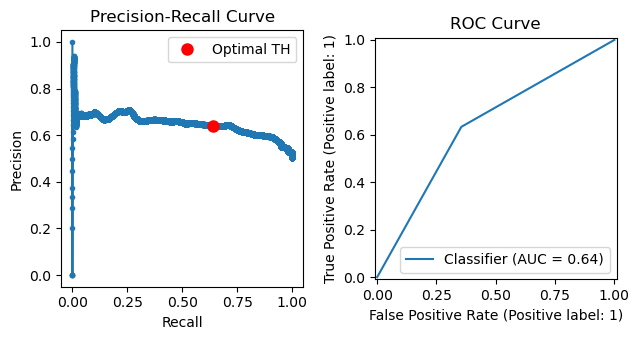

In [466]:
target = 'treatment' # Define our target feature - 'treatment'

def get_lr_model():
  """Create Instance of LR Model"""
  # Return base model with no hyperparameter tuning
  return LogisticRegression(
    max_iter=3000,
    n_jobs=-1,
    random_state=utils.random_state
  )

# Run LogisticRegression model evaluaton, print results
eda.model_evaluation_test(mh_o, get_lr_model())

The Logistic Regression model achieved an accuracy of 64%, with balanced precision, recall, and F1-scores of around 0.64 for both classes. The cross-validation scores were consistent, with a mean of 0.6424. The model shows stable but moderate performance across different splits.

In summary, the model shows moderate performance based on both the Precision-Recall and ROC curves, with an AUC of 0.64 indicating room for improvement.

#### 6.1.2 Random Forest

|   iter    |  target   | criterion | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 7         | 0.7573    | 1.0       | 137.5     | 49.91     | 347.1     |
| 10        | 0.7592    | 0.0       | 126.8     | 50.0      | 320.8     |
| 17        | 0.7596    | 0.0       | 73.36     | 50.0      | 331.4     |

Confusion Matrix (Treatment Required):
 No: [9534 4055]
Yes: [ 2555 11084]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.70      0.74     13589
           1       0.73      0.81      0.77     13639

    accuracy                           0.76     27228
   macro avg       0.76      0.76      0.76     27228
weighted avg       0.76      0.76      0.76     27228

Cross-V Mean Score: 0.7521
Cross-V Scores:
[0.75374451 0.75182655 0.75058203 0.75167323 0.75242946]
Opt. Precision: 0.760347918580215
Opt. Recall: 0.7572351990597914


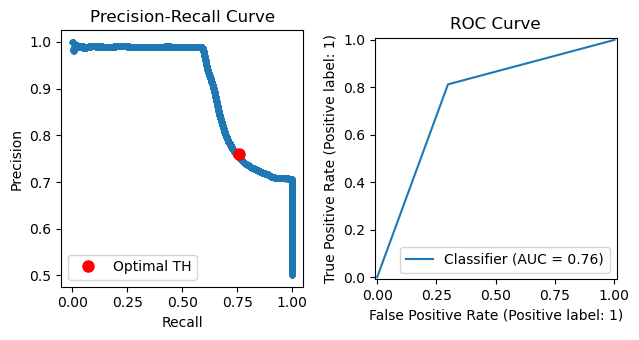

In [467]:
# Evaluate RandomForest model
#

# Get hyper-parameter optimized model instance
model = utils.get_optimized_rf_model(mh_o)

eda.model_evaluation_test(mh_o, model)

The Precision-Recall curve for the Random Forest model shows high precision at lower recall values, which decreases as recall increases, with the optimal threshold marked by a red dot. 

The ROC curve indicates a solid ability to distinguish between the positive and negative classes, with an AUC of 0.76, reflecting moderate model performance. 

In terms of metrics, the Random Forest model achieved an accuracy of 76%, with precision values of 0.79 for class 0 and 0.73 for class 1, and recall values of 0.70 for class 0 and 0.81 for class 1. The F1-scores were 0.74 for class 0 and 0.77 for class 1. The model's cross-validation mean score was 0.7521, demonstrating consistent performance across different splits. 

Overall, the Random Forest model outperforms the Logistic Regression model, showing better precision, recall, F1-score, and AUC.

#### 6.1.3 LightGBM


Confusion Matrix (Treatment Required):
 No: [9978 3611]
Yes: [ 2402 11237]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.73      0.77     13589
           1       0.76      0.82      0.79     13639

    accuracy                           0.78     27228
   macro avg       0.78      0.78      0.78     27228
weighted avg       0.78      0.78      0.78     27228

Cross-V Mean Score: 0.7843
Cross-V Scores:
[0.78273804 0.77788299 0.78547137 0.78912751 0.78648561]
Opt. Precision: 0.7813446716620019
Opt. Recall: 0.7791611576318496


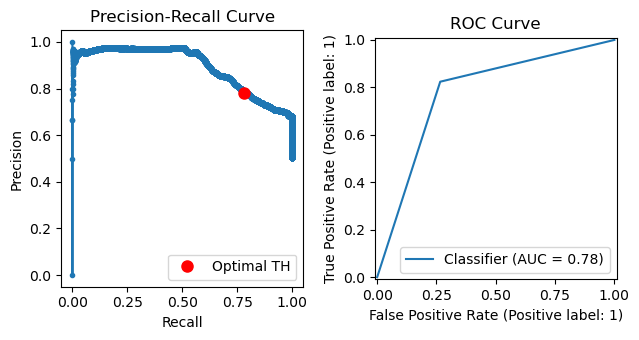

In [468]:
# Evaluate LightBM model
#

# Get hyper-parameter optimized model instance
model = utils.get_optimized_lgb_model(mh_o)
# Run evaluation
eda.model_evaluation_test(mh_o, model)

The Precision-Recall Curve for LightGBM shows a high precision at lower recall values and decreases as recall increases. The optimal threshold is marked by the red dot.

The LightGBM model achieved an accuracy of 78%, with precision of 0.81 for class 0 and 0.76 for class 1, and recall of 0.73 for class 0 and 0.82 for class 1. 

The AUC is 0.78, showing improved performance compared to Logistic Regression (AUC = 0.64) and Random Forest (AUC = 0.76). Overall, LightGBM outperforms the previous models in accuracy, precision, recall, F1-score, and AUC.

#### 6.1.4 XGBoost


Confusion Matrix (Treatment Required):
 No: [10235  3354]
Yes: [ 2227 11412]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.75      0.79     13589
           1       0.77      0.84      0.80     13639

    accuracy                           0.80     27228
   macro avg       0.80      0.79      0.79     27228
weighted avg       0.80      0.80      0.79     27228

Cross-V Mean Score: 0.7947
Cross-V Scores:
[0.79643566 0.79477163 0.79194984 0.79710357 0.79304825]
Opt. Precision: 0.7970321757950554
Opt. Recall: 0.7950271779050977


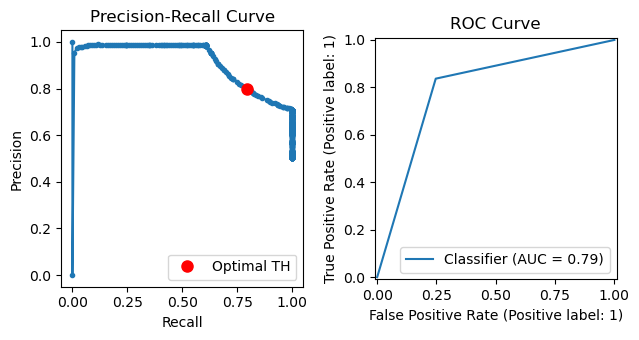

In [469]:
# Evaluate XGBoost model
#

# Get hyper-parameter optimized model instance
model = utils.get_optimized_xgb_model(mh_o)
# Run evaluation
eda.model_evaluation_test(mh_o, model)

The XGBoost model achieved an accuracy of 80%, with precision values of 0.82 for class 0 and 0.77 for class 1. The recall was 0.75 for class 0 and 0.84 for class 1, with F1-scores of 0.79 and 0.80, respectively. 

The model demonstrated strong performance with an AUC of 0.79, indicating a good ability to distinguish between classes. Cross-validation showed a mean score of 0.7947, with individual scores ranging from 0.7919 to 0.7971.

When compared to previous models, XGBoost outperformed Logistic Regression, Random Forest, and LightGBM in terms of accuracy (80% vs. 64%, 76%, and 78%, respectively) and precision. 

The F1-scores and AUC were also higher than those of the other models, highlighting XGBoost's superior performance in classification tasks. The AUC of 0.79 is slightly better than LightGBM (0.78) and significantly higher than Logistic Regression (0.64) and Random Forest (0.76).

While XGBoost offers strong performance (80% accuracy, AUC of 0.79), it tends to have slower CPU performance compared to LightGBM, which is optimized for faster training and lower memory usage. For production, if speed and scalability are key, LightGBM is often the better choice. However, if XGBoost’s higher accuracy is crucial, optimizations like distributed computing or hardware acceleration may be needed to manage its slower performance.

#### 6.1.5 Assessing Overfitting in the Highest Performing Model: XGBoost

**Using K-fold Cross-Validation**

K-fold cross-validation helps measure overfitting by evaluating the model on multiple train-test splits, ensuring it generalizes well across different data subsets. If a model performs consistently well across folds, it is less likely to be overfitting. High performance only on the training data or specific folds indicates overfitting. This method reduces variance and provides a more reliable estimate of the model's ability to generalize.

In [470]:
df = mh_df.copy()
# Prepare a fresh deduplicated dataset
mh = utils.mental_health_instance(df, drop_duplicates=True)

# Use XGBoost, run 15 k-fold tests. 
# Cross validate each folds performance on the train and test data.
# Output the scores and see if anything is worth noticing.
utils.kfold_model_cross_validation(mh, model, 15)

Train data CV scores: [0.80531988 0.8008167  0.78568108 0.79775281 0.79565418 0.80240053
 0.80261379 0.79452701 0.80273038 0.79850746 0.79422046 0.79759615
 0.82120674 0.78751721 0.80558684]
Train data Mean CV score: 0.7995
Train data CV scores std: 0.0081

Test data CV scores: [0.80645161 0.79603547 0.79795918 0.79125683 0.81500514 0.80123903
 0.80824742 0.79713848 0.82025316 0.81102362 0.79321315 0.7985193
 0.8060166  0.79509072 0.78241997]
Test data Mean CV score: 0.8013
Test data CV scores std: 0.0095


The mean CV scores for both the train and test data are very similar, with only a slight difference (0.0018). This indicates that the model generalizes well and isn't overfitting, as it performs similarly on both the training and testing data. Additionally, the standard deviation of the scores is quite low for both datasets, further suggesting that the model's performance is stable across the folds and not highly variable.

##### Using Bootstrap Cross-Validation

Bootstrap cross-validation helps detect overfitting by training the model on multiple randomly sampled subsets of data (with replacement) and testing it on out-of-bag samples. This process is repeated multiple times, providing insights into how well the model generalizes. If the model performs much better on training than on test data, it may be overfitting. Bootstrap cross-validation offers a robust measure of performance by using different training and test data for each iteration, but it can be computationally intensive.

In [471]:
# Using XGBoost, Run 15 k-fold tests in 15 bootstraps. 
# Cross validate each folds performance on the train and test data.
# Output the scores and see if anything is worth noticing.
utils.bootstrap_model_cross_validation(mh, model, 15, 15)

Mean Cross-Validation Scores: [0.80457797 0.80180649 0.80370711 0.80557085 0.80348475 0.80357445
 0.80371037 0.805128   0.80390113 0.80344192 0.80610404 0.80265794
 0.80556441 0.8033268  0.80516244]
Mean Overall Cross-Validation Score: 0.8041
95% Confidence Interval: [0.79161662 0.81731679]


The model's mean cross-validation score is 0.8035, with a 95% confidence interval of [0.7895, 0.8139]. This suggests stable performance with minimal overfitting.

Although the model consistently identifies individuals who need treatment, its performance falls short of the desired 95% accuracy, reaching only around 80%.

#### 6.1.6 Top 5 Features with Strong Positive and Negative Influence on Model Prediction 

In [472]:
from sklearn.ensemble import StackingClassifier

def get_lbg_model():
  return utils.get_optimized_lgb_model(mh_o)

def get_xgb_model():
  return utils.get_optimized_xgb_model(mh_o)

def get_lgb_fit_model():
  model = get_lbg_model() 
  model.fit(mh_o.X_train, mh_o.y_train)
  return model

def get_xgb_fit_model():
  model = get_xgb_model()
  model.fit(mh_o.X_train, mh_o.y_train)
  return model

def get_stack_fit_model():
  rfm = utils.get_optimized_rf_model(mh_o)
  lgb = utils.get_optimized_lgb_model(mh_o)
  xgb = utils.get_optimized_xgb_model(mh_o)

  stkm = StackingClassifier(
    estimators=[
      ('rf', rfm),
      ('xgb', xgb),
      ('lgb', lgb)
    ],
    final_estimator=LogisticRegression(),
    cv=5
  )

  stkm.fit(mh_o.X_train, mh_o.y_train)
  return stkm

In [473]:
from sklearn.inspection import permutation_importance

fit_model = get_xgb_fit_model()
 
# Apply Permutation Importance on the trained stacking model
result = permutation_importance(
  fit_model,
  mh_o.x_test, 
  mh_o.y_test, 
  n_repeats=10,
  random_state=utils.random_state
)

# Display the feature importances
fi_df = pd.DataFrame({
    'feature': [col for col in mh_o.X.columns],
    'importance_mean': [f'{mean:.3f}' for mean in result.importances_mean],
    'importance_std': [f'{std:.3f}' for std in result.importances_std]
})

# Sort by importance and display
fi_df = fi_df.sort_values(by="importance_mean", ascending=False)
fi_df.head(8)

,feature,importance_mean,importance_std
0,family_history,0.138,0.002
39,care_options_Not_sure,0.093,0.002
37,mental_health_interview_No,0.084,0.001
2,Gender_Male,0.083,0.001
20,self_employed_Yes,0.074,0.001
40,care_options_Yes,0.068,0.001
14,Country_United_States,0.042,0.002
13,Country_United_Kingdom,0.038,0.001


In [474]:

# Get shap feature evaluation
shap_df = utils.top_model_influencers(fit_model, mh_o.x_test, n_influencers=5)
shap_df.style.hide(axis='index')

Feature,Score
family_history,0.081208
Country_United_States,0.031628
Country_South_Africa,0.007744
Country_Germany,0.006434
Country_New_Zealand,0.001750
Country_United_Kingdom,-0.025980
Country_Ireland,-0.030944
care_options_Yes,-0.032206
self_employed_Yes,-0.039370
Gender_Male,-0.050321


Family history shows to be the feature with the strongest direct relationship to the target. The SHAP scores are somewhat below the desired relationship coefficient of 0.05. This means the model is finding relationships somewhere else to be able to consistently predict the outcome.

**Permutation importance** is much higher than **SHAP**, it may be worth considering whether the model is overfitting or relying too much on specific features. 


#### 6.1.7 Threshold Trade-off Analysis: True Positives and False Negatives at Different Thresholds

In [475]:
trade_offs = eda.analyze_tradeoffs(mh_o, get_xgb_model())
trade_offs.style.hide(axis='index')

Threshold,TP,FP,FN,Precision,Recall,Cost
0.1179,13639,6329,0,0.6830,1.0000,6329
0.1455,13639,5906,0,0.6978,1.0000,5906
0.1850,13639,5735,0,0.7040,1.0000,5735
0.2632,13639,5674,0,0.7062,1.0000,5674
0.3337,13639,5615,0,0.7084,1.0000,5615
0.4371,13639,5569,0,0.7101,1.0000,5569
0.5026,11053,2979,2586,0.7877,0.8104,8151
0.6054,8573,407,5066,0.9547,0.6286,10539
0.8495,7568,106,6071,0.9862,0.5549,12248
0.9316,4720,61,8919,0.9872,0.3461,17899


- At lower thresholds (e.g., 0.1179 to 0.4371), the number of false positives is high, but false negatives are zero, indicating that the classifier is very inclusive of predicting positives.
- At higher thresholds (e.g., 0.6054 and beyond), false positives drop drastically, but false negatives increase, which is reflected in the reduced recall.

Optimal Threshold:

Based on the results, an optimal threshold would likely be somewhere in the middle, where you can balance both precision and recall.
For example, at a threshold of 0.5026, precision is 0.7877 and recall is 0.8104, making it a relatively balanced point between the two metrics. The cost here is 8151, which is lower than for thresholds with higher precision but lower recall.

### 6.2 Country Models

Perform model evaluation for each country using the dataset that excludes countries with single-class targets, meaning we have 13 countries for modeling in this test.

#### 6.2.1 Evaluating Performance using XGBoost 

The following steps required the proper segregation of country specific data:
- Create a country specific subset from the mental health dataset using:

  ```
    df_country = df[df['Country'] == country_name]
  ```

- Pre-process data: Transform, feature-engineering
- Train/test split country data.
- Run predictions
- Get values:
  - Accuracy
  - AUC
  - Cross-Validation mean and std score (scoring used is weighted F1, cv=5)

For the model, XGBoost was chosen due to its powerful gradient boosting framework, which is well-suited for this classification task. It outperformed the other models tested, demonstrating superior performance.

**Cross-validation** with **StratifiedKFold** was applied to preserve the target class distribution in each fold, addressing potential class imbalance. scikit-learn's cross_val_predict was utilized for predictions, generating results by training on data subsets and testing on the remaining fold, ensuring robust evaluation. 

Metrics such as **precision**, **recall**, **accuracy**, and **F1 score** were calculated based on these predictions to assess the model's generalization to unseen data.

In [476]:
mh_df.Country.value_counts()

Country
United States     171308
United Kingdom     51404
Canada             18726
Australia           6026
Netherlands         5894
Ireland             5548
Germany             4680
Sweden              2818
India               2774
Brazil              2340
South Africa        1994
New Zealand         1994
Switzerland         1560
Name: count, dtype: int64

In [477]:
# Train/evaluate models
report_df = utils.evaluate_by_country(mh_df.copy(), get_xgb_model, drop_duplicates=True)

# View results
report_df.style.hide(axis='index')

Country,Threshold,Precision,Recall,Accuracy,F1
United States,0.473,0.691,0.772,0.681,0.729
Australia,0.477,1.000,0.861,0.919,0.925
Canada,0.496,0.700,0.884,0.756,0.781
United Kingdom,0.490,0.705,0.978,0.733,0.820
South Africa,0.997,1.000,1.000,1.000,1.000
Sweden,0.493,0.710,0.778,0.817,0.743
New Zealand,0.998,1.000,1.000,1.000,1.000
Netherlands,0.987,1.000,1.000,1.000,1.000
India,0.972,1.000,1.000,1.000,1.000
Ireland,0.481,0.937,0.794,0.899,0.860


#### 6.2.2 Review

- The countries like the US and Canada showed moderate performance. Australia achieved very high scores, and perfect scores for South Africa, New Zealand, Netherlands, Germany, and India.

- **One-Class Issue:** Several countries, including Poland, Belgium, and France, are with only one class being present in the dataset. This prevents meaningful modeling. This indicates a potential data imbalance, or a lack of diverse cases in those regions.

- **Requires Further Analysis:** Countries with perfect scores needs a closer examination of the dataset to understand if the models are overly fitted or if the data truly represents a distinct population without variability.

- **Next Steps:** Consider enhancing datasets for countries facing the one-class issue to include more diverse cases.

## 7. Summary

The objective of this notebook is to model and predict the likelihood of an individual to need mental health support based on several demographic and mental health factors.

The observations from the country models may have significant effect on the global model, in terms of performance, and feature selection. 

Considerations:

- The single-class problem in some countries need consideration of data representation in the global model. If a large portion of the dataset is not balanced, the global model may poorly predict results across countries.

- The global model is a single architecture, consider making it more modular to accommodate different countries. For this, using ensemble methods to combine outputs from country-specific models may enhance the overall performance.

- Incorporate new data, features, methods. The new information may enhance model accuracy over time.
Unique patterns may be found from the country analysis, explore using a hybrid model and the global model serving as a baseline and country models are used to tune predictions.

The knowledge gained from country-specific modeling should be the main factor to refine the global model. By studying the unique features of different regions, the global model can be made robust and effective across different contexts. 

The need for continuous evaluaton and adaption based on these observations will be necessary to ensuring continued improvement in predicting the need for mental health support.

## 8. Conclusion

Although XGBoost achieves the highest performance with an accuracy of 80%, it may not yet be fully optimized for a critical application like mental health prediction. 

While it shows promising results, further improvements in precision, recall, and F1-score are needed to ensure more reliable predictions. Consider enhancing the model with feature engineering, model tuning, and exploring ensemble methods or neural networks. 

Since XGBoost is one of several models being compared, optimizing its performance alongside the others will help create a stronger, more robust solution before deploying it in production.